In [1]:
import os, json
from pathlib import Path
from typing import List, Dict, Tuple, Optional
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

TRAIN_IMG_ROOT = Path("/media/kursat/TOSHIBA_EXT/projects/routhwise/driverms/data/bdd100k/bdd100k/bdd100k/images/train")
VAL_IMG_ROOT   = Path("/media/kursat/TOSHIBA_EXT/projects/routhwise/driverms/data/bdd100k/bdd100k/bdd100k/images/val")

TRAIN_JSON = Path("/media/kursat/TOSHIBA_EXT/projects/routhwise/driverms/data/bdd100k/bdd100k_labels_release/bdd100k/labels/bdd100k_labels_images_train.json") 
VAL_JSON   = Path("/media/kursat/TOSHIBA_EXT/projects/routhwise/driverms/data/bdd100k/bdd100k_labels_release/bdd100k/labels/bdd100k_labels_images_val.json")    

for p in [TRAIN_IMG_ROOT, VAL_IMG_ROOT, TRAIN_JSON, VAL_JSON]:
    assert p.exists(), f"Not found: {p}"
print("OK: all paths exist.")

OK: all paths exist.


In [2]:
import numpy as np
import cv2
from typing import List, Dict, Tuple, Optional


def resize_points(pts: np.ndarray, src_wh: Tuple[int, int], dst_wh: Tuple[int, int]) -> np.ndarray:
    """Resize 2D points from source (w, h) to destination (w, h)."""
    if pts.size == 0:
        return pts.astype(np.float32)
    sw, sh = src_wh
    dw, dh = dst_wh
    sx, sy = dw / float(sw), dh / float(sh)
    out = pts.astype(np.float32).copy()
    out[:, 0] *= sx
    out[:, 1] *= sy
    return out


def poly2d_fill_mask(mask: np.ndarray, polys: List[np.ndarray]) -> None:
    """Fill polygon regions in the given mask with value 1."""
    if not polys:
        return
    polys_int = []
    for p in polys:
        if p.size == 0:
            continue
        polys_int.append(p.astype(np.int32).reshape(-1, 1, 2))
    if polys_int:
        cv2.fillPoly(mask, polys_int, 1)


def poly2d_draw_lines(mask: np.ndarray, lines: List[np.ndarray], thickness: int = 2) -> None:
    """Draw polyline annotations (e.g., lanes) into the mask with value 1."""
    if not lines:
        return
    for p in lines:
        if p.size == 0:
            continue
        cv2.polylines(mask, [p.astype(np.int32)], isClosed=False, color=1, thickness=thickness)


def parse_item_annotations(
    it: dict,
    img_shape_hw: Tuple[int, int],
    dst_hw: Optional[Tuple[int, int]] = None,
    attr_maps: Optional[Dict[str, Dict[str, int]]] = None,
    lane_categories: Tuple[str, ...] = ("lane",),
    drivable_category: str = "drivable area",
    lane_thickness: int = 2,
    add_channel_dim: bool = True,
) -> Tuple[Dict[str, int], np.ndarray, np.ndarray]:
    """
    Parse a single BDD100K annotation item for:
      - image-level attributes (weather, scene, timeofday)
      - lane mask
      - drivable area mask

    Returns:
        attr_ids:   dict with image-level attributes (weather, scene, timeofday)
        lane_mask:  (H_t, W_t) or (1, H_t, W_t) uint8 mask for lane markings
        driv_mask:  (H_t, W_t) or (1, H_t, W_t) uint8 mask for drivable area
    """
    # Original image shape (height, width)
    H, W = img_shape_hw

    # Target shape (height, width)
    Ht, Wt = img_shape_hw if dst_hw is None else dst_hw

    # Scale factors from original image size to target size
    sx, sy = Wt / float(W), Ht / float(H)

    # Scale lane thickness according to resize
    t_scaled = max(1, int(round(lane_thickness * min(sx, sy))))

    # Utility: normalize strings (case-insensitive, trim, fallback to "undefined")
    def _norm(s):
        if not isinstance(s, str):
            return "undefined"
        s = s.strip().lower()
        return s if s else "undefined"

    # Precompute category sets for lanes and drivable area
    lane_cat_set = {_norm(c) for c in lane_categories}
    drv_cat_norm = _norm(drivable_category)

    # Image-level attributes
    attrs = it.get("attributes", {}) or {}

    def amap(key: str, val: str) -> int:
        """Map attribute string to integer id using attr_maps."""
        key_n = key.lower()
        m = (attr_maps or {}).get(key_n, {}) or {}
        val_n = _norm(val)
        # Fallback to "undefined" or 0 if not found
        return m.get(val_n, m.get("undefined", 0))

    attr_ids = {
        "weather": amap("weather", attrs.get("weather", "undefined")),
        "scene": amap("scene", attrs.get("scene", "undefined")),
        "timeofday": amap("timeofday", attrs.get("timeofday", "undefined")),
    }

    # Segmentation masks: lanes (lines) and drivable area (filled polygons)
    lane_mask = np.zeros((Ht, Wt), dtype=np.uint8)
    driv_mask = np.zeros((Ht, Wt), dtype=np.uint8)

    for lab in it.get("labels", []):
        if "poly2d" not in lab:
            continue

        cat = _norm(lab.get("category", ""))

        polys: List[np.ndarray] = []
        for poly in lab["poly2d"]:
            verts = np.asarray(poly.get("vertices", []), dtype=np.float32)
            if verts.size == 0:
                continue
            verts = resize_points(verts, (W, H), (Wt, Ht))
            polys.append(verts)

        # Lanes: draw as polylines
        if cat in lane_cat_set:
            poly2d_draw_lines(lane_mask, polys, thickness=t_scaled)

        # Drivable area: fill polygons
        if cat == drv_cat_norm:
            poly2d_fill_mask(driv_mask, polys)

    if add_channel_dim:
        lane_mask = lane_mask[None, ...]   # (1, H_t, W_t)
        driv_mask = driv_mask[None, ...]   # (1, H_t, W_t)

    return attr_ids, lane_mask, driv_mask

In [3]:
# === BDD100K Multi-Task Dataset cell (clean, drop-in) ===
import os
from pathlib import Path
from typing import List, Dict, Tuple, Optional
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset

# ----------------------------
# Image indexing & resolution
# ----------------------------
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp"}

def build_filename_index(search_dirs: List[Path]) -> Dict[str, str]:
    """
    Recursively index all image files under given directories.
    Returns dict: {basename: full_path}. If duplicates appear, the last one wins.
    """
    index: Dict[str, str] = {}
    for d in search_dirs:
        d = Path(d)
        if not d.exists():
            continue
        for root, _, files in os.walk(d):
            for fn in files:
                ext = os.path.splitext(fn)[1].lower()
                if ext in IMG_EXTS:
                    index[fn] = str(Path(root) / fn)
    return index

def resolve_image_path(img_root: Path, name: str, fallback_index: Dict[str, str]) -> Optional[Path]:
    """
    Try img_root/name; else try basename via fallback index; else None.
    """
    p = img_root / name
    if p.exists():
        return p
    base = os.path.basename(name)
    if base in fallback_index:
        return Path(fallback_index[base])
    if name in fallback_index:  # rare case: index keyed by relpath
        return Path(fallback_index[name])
    return None

# ----------------------------------------------------
# Dataset: attributes + lane + drivable (no boxes)
# ----------------------------------------------------
class BDDMultiTaskDataset(Dataset):
    """
    Multitask dataset: attributes + lane + drivable (no detection).

    Expects a previously-defined helper:
        parse_item_annotations(it, img_shape_hw, dst_hw, attr_maps,
                               lane_categories, drivable_category, lane_thickness, ...)
    which returns: (attr_ids, lane_mask(1,H,W), driv_mask(1,H,W))
    """
    def __init__(self,
                 img_root: Path,
                 items: List[dict],
                 attr_maps: Dict[str, Dict[str, int]],
                 target_size: Optional[Tuple[int, int]] = None,  # (H, W)
                 to_tensor: bool = True,
                 filename_index: Optional[Dict[str, str]] = None,
                 lane_categories: Tuple[str, ...] = ("lane",),
                 drivable_category: str = "drivable area",
                 lane_thickness: int = 2):
        self.img_root = Path(img_root)
        self.attr_maps = attr_maps
        self.target_size = target_size  # (H, W)
        self.to_tensor = to_tensor
        self.filename_index = filename_index or {}
        self.lane_categories = lane_categories
        self.drivable_category = drivable_category
        self.lane_thickness = lane_thickness

        # Pre-filter items by resolvable image path (silently skip missing)
        valid_items: List[dict] = []
        for it in items:
            name = it.get("name", None)
            if not isinstance(name, str):
                continue
            p = resolve_image_path(self.img_root, name, self.filename_index)
            if p is None:
                continue
            it_copy = dict(it)  # shallow copy to attach resolved path
            it_copy["_resolved_path"] = str(p)
            valid_items.append(it_copy)

        self.items = valid_items
        self.names = [it["name"] for it in self.items]

    def __len__(self) -> int:
        return len(self.items)

    def __getitem__(self, idx: int) -> Dict:
        it = self.items[idx]
        img_path = Path(it["_resolved_path"])
        img = cv2.imread(str(img_path))
        if img is None:
            raise FileNotFoundError(f"Image not readable (filtered expected): {img_path}")

        H, W = img.shape[:2]
        if self.target_size is not None:
            Ht, Wt = self.target_size
            if (H, W) != (Ht, Wt):
                img = cv2.resize(img, (Wt, Ht), interpolation=cv2.INTER_LINEAR)
        else:
            Ht, Wt = H, W

        # Parse annotations (expects helper to be defined earlier in the notebook)
        attr_ids, lane_mask, driv_mask = parse_item_annotations(
            it,
            img_shape_hw=(H, W),
            dst_hw=(Ht, Wt),
            attr_maps=self.attr_maps,
            lane_categories=self.lane_categories,
            drivable_category=self.drivable_category,
            lane_thickness=self.lane_thickness,
        )

        if self.to_tensor:
            # BGR -> RGB, float [0,1], CHW
            img_t  = torch.from_numpy(img[:, :, ::-1].copy()).permute(2, 0, 1).to(dtype=torch.float32) / 255.0
            # masks already (1,H,W); convert to float for BCE/ Dice losses
            lane_t = torch.from_numpy(lane_mask).to(dtype=torch.float32)
            driv_t = torch.from_numpy(driv_mask).to(dtype=torch.float32)
            attrs_t = {
                "weather":   torch.as_tensor(attr_ids["weather"], dtype=torch.long),
                "scene":     torch.as_tensor(attr_ids["scene"], dtype=torch.long),
                "timeofday": torch.as_tensor(attr_ids["timeofday"], dtype=torch.long),
            }
            return {
                "image": img_t,                  # (3,H,W) float32
                "attrs": attrs_t,                # dict of Long tensors
                "lane_mask": lane_t,             # (1,H,W) float32 in {0,1}
                "drivable_mask": driv_t,         # (1,H,W) float32 in {0,1}
                "name": it["name"],
                "image_path": str(img_path),
                "size": (Ht, Wt),
            }
        else:
            return {
                "image_bgr": img,                # (H,W,3) uint8
                "attrs": attr_ids,               # dict of ints
                "lane_mask": lane_mask,          # (1,H,W) uint8
                "drivable_mask": driv_mask,      # (1,H,W) uint8
                "name": it["name"],
                "image_path": str(img_path),
                "size": (Ht, Wt),
            }

In [4]:
from typing import List, Dict
import torch


def multitask_collate(batch: List[Dict]) -> Dict:
    """
    Custom collate function for the BDDMultiTaskDataset (no detection).

    Expects each sample in batch to be a dict with keys:
        - "image":          (3,H,W) float32
        - "attrs":          dict of {"weather","scene","timeofday"} → scalar Long tensors
        - "lane_mask":      (1,H,W) float32 tensor
        - "drivable_mask":  (1,H,W) float32 tensor
        - "name":           str
        - "image_path":     str
        - "size":           (H,W)

    Returns:
        - images:        (B,3,H,W) float32
        - attrs:         dict of Long tensors (B,)
        - lane_mask:     (B,1,H,W) float32
        - drivable_mask: (B,1,H,W) float32
        - names:         list[str]
        - sizes:         list[Tuple[int,int]]
        - image_paths:   list[str]
    """
    # Images (assumes all samples have same H,W)
    images = torch.stack(
        [b["image"].contiguous() for b in batch],
        dim=0
    ).to(dtype=torch.float32)

    # Attributes (stack scalars to shape (B,))
    weather = torch.stack(
        [b["attrs"]["weather"] for b in batch], dim=0
    )
    scene = torch.stack(
        [b["attrs"]["scene"] for b in batch], dim=0
    )
    timeofday = torch.stack(
        [b["attrs"]["timeofday"] for b in batch], dim=0
    )

    attrs = {
        "weather": weather,
        "scene": scene,
        "timeofday": timeofday,
    }

    # Masks come as (1,H,W) → stack to (B,1,H,W)
    lane_mask = torch.stack(
        [b["lane_mask"].to(dtype=torch.float32).contiguous() for b in batch],
        dim=0
    )
    drivable_mask = torch.stack(
        [b["drivable_mask"].to(dtype=torch.float32).contiguous() for b in batch],
        dim=0
    )

    # Meta info
    names = [b["name"] for b in batch]
    sizes = [b["size"] for b in batch]
    image_paths = [b["image_path"] for b in batch]

    return {
        "images": images,
        "attrs": attrs,
        "lane_mask": lane_mask,
        "drivable_mask": drivable_mask,
        "names": names,
        "sizes": sizes,
        "image_paths": image_paths,
    }


In [5]:
# === Build loaders (deterministic filename index + fixed target size) with 10k-train subsample ===
from pathlib import Path
from typing import List, Optional, Dict
import json
import random
from torch.utils.data import DataLoader

# ---- Helpers: load + vocab builders ----
def load_annotation_items(json_path: Path) -> List[dict]:
    """Load BDD-style JSON and normalize to a list of items.
    Supports either top-level list OR {'root': [...]} wrapper.
    """
    with open(json_path, "r") as f:
        data = json.load(f)

    if isinstance(data, list):
        return data

    if isinstance(data, dict):
        if "root" in data and isinstance(data["root"], list):
            return data["root"]
        # Fallback common keys
        for k in ["frames", "items", "labels", "data"]:
            if k in data and isinstance(data[k], list):
                return data[k]

    raise ValueError("Unsupported JSON structure: expected list or {'root': [...]}.")


def _norm_str(s: str) -> str:
    """Normalize a string similar to parse_item_annotations: strip + lower, fallback to 'undefined'."""
    if not isinstance(s, str):
        return "undefined"
    s = s.strip().lower()
    return s if s else "undefined"


def build_attribute_maps_from_items(*splits: List[dict]) -> Dict[str, Dict[str, int]]:
    """Collect vocabularies for weather/scene/timeofday across splits."""
    weather, scene, tod = set(), set(), set()

    for items in splits:
        for it in items:
            attrs = it.get("attributes", {}) or {}
            if "weather" in attrs:
                weather.add(_norm_str(attrs["weather"]))
            if "scene" in attrs:
                scene.add(_norm_str(attrs["scene"]))
            if "timeofday" in attrs:
                tod.add(_norm_str(attrs["timeofday"]))

    def make_map(values: set) -> Dict[str, int]:
        # Ensure 'undefined' exists and is index 0
        vals = {"undefined"} | {v for v in values if v != "undefined"}
        vals = ["undefined"] + sorted(v for v in vals if v != "undefined")
        return {v: i for i, v in enumerate(vals)}

    return {
        "weather": make_map(weather),
        "scene": make_map(scene),
        "timeofday": make_map(tod),
    }


# ---- Load annotations ----
items_train = load_annotation_items(TRAIN_JSON)
items_val   = load_annotation_items(VAL_JSON)

print(f"train items: {len(items_train)} | val items: {len(items_val)}")
print("sample keys:", items_train[0].keys())

# ---- Build vocabularies over all items (for attributes only) ----
ATTR_MAPS = build_attribute_maps_from_items(items_train, items_val)

print("ATTR_MAPS:", {k: list(v.keys()) for k, v in ATTR_MAPS.items()})

# ---- Deterministic search roots for filename index (non-existing are skipped in build_filename_index) ----
_search_roots_ordered: List[Path] = [
    TRAIN_IMG_ROOT,
    VAL_IMG_ROOT,
    TRAIN_IMG_ROOT.parent, TRAIN_IMG_ROOT.parent.parent, TRAIN_IMG_ROOT.parent.parent.parent,
    VAL_IMG_ROOT.parent,   VAL_IMG_ROOT.parent.parent,   VAL_IMG_ROOT.parent.parent.parent,
]

_seen = set()
_search_roots: List[Path] = []
for p in _search_roots_ordered:
    if p not in _seen:
        _seen.add(p)
        _search_roots.append(p)

FILENAME_INDEX = build_filename_index(_search_roots)
print(f"Filename index built over {len(_search_roots)} roots; {len(FILENAME_INDEX):,} files indexed.")

# ---- Subsample train to exactly 10k images (deterministic) ----
MAX_TRAIN_IMAGES = 100000
RNG_SEED = 1337  # deterministic selection

if len(items_train) <= MAX_TRAIN_IMAGES:
    print(
        f"[info] Train items ({len(items_train)}) <= MAX_TRAIN_IMAGES ({MAX_TRAIN_IMAGES}). "
        f"Using all train items."
    )
    items_train_subset = items_train
else:
    rng = random.Random(RNG_SEED)
    items_train_subset = rng.sample(items_train, MAX_TRAIN_IMAGES)
    print(f"[train subset] images: {len(items_train_subset)} (subsampled from {len(items_train)})")

# ---- Fixed target size ----
TARGET_SIZE = (384, 640)  # (H, W), multiples of 32

# ---- Datasets ----
train_dataset = BDDMultiTaskDataset(
    img_root=TRAIN_IMG_ROOT,
    items=items_train_subset,   # only 10k images
    attr_maps=ATTR_MAPS,
    target_size=TARGET_SIZE,
    to_tensor=True,
    filename_index=FILENAME_INDEX,
)

val_dataset = BDDMultiTaskDataset(
    img_root=VAL_IMG_ROOT,
    items=items_val,
    attr_maps=ATTR_MAPS,
    target_size=TARGET_SIZE,
    to_tensor=True,
    filename_index=FILENAME_INDEX,
)

# ---- DataLoaders ----
train_loader = DataLoader(
    train_dataset,
    batch_size=16,            # adjust if OOM; 16–32 is safer on 12–24GB GPUs
    shuffle=True,
    num_workers=8,
    pin_memory=True,
    collate_fn=multitask_collate,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=8,
    pin_memory=True,
    collate_fn=multitask_collate,
)

print(f"train pairs: {len(train_dataset)} | val pairs: {len(val_dataset)}")

train items: 69863 | val items: 10000
sample keys: dict_keys(['name', 'attributes', 'timestamp', 'labels'])
ATTR_MAPS: {'weather': ['undefined', 'clear', 'foggy', 'overcast', 'partly cloudy', 'rainy', 'snowy'], 'scene': ['undefined', 'city street', 'gas stations', 'highway', 'parking lot', 'residential', 'tunnel'], 'timeofday': ['undefined', 'dawn/dusk', 'daytime', 'night']}
Filename index built over 5 roots; 105,740 files indexed.
[info] Train items (69863) <= MAX_TRAIN_IMAGES (100000). Using all train items.
train pairs: 69863 | val pairs: 10000


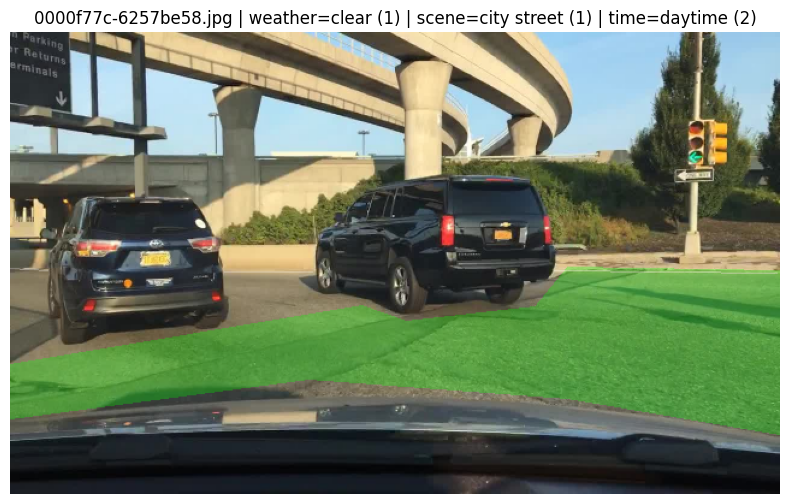

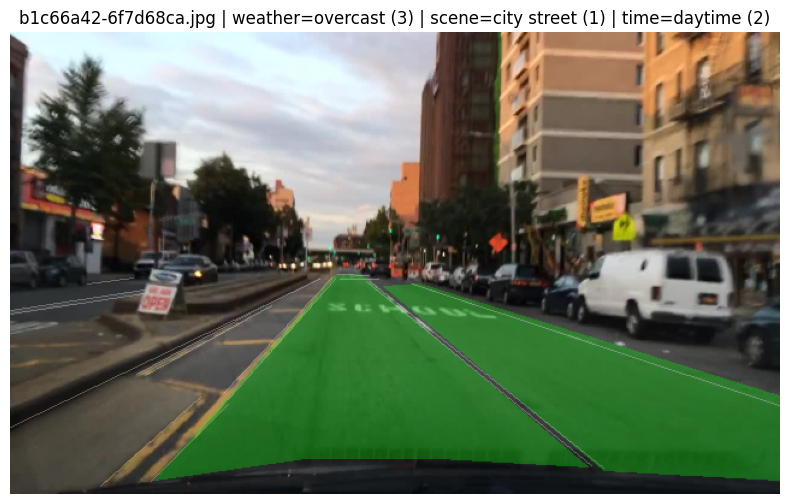

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch
from typing import Dict

def _to_bool_mask(x: torch.Tensor) -> np.ndarray:
    """
    Accepts (H,W) or (1,H,W) torch tensors (float/uint8) and returns (H,W) bool numpy array.
    """
    if x.dim() == 3 and x.shape[0] == 1:
        x = x.squeeze(0)
    return x.detach().cpu().numpy().astype(bool)

def _invert_map(m: Dict[str,int]) -> Dict[int,str]:
    return {v:k for k,v in m.items()}

# Optional: reverse maps for attributes (id -> name)
ATTR_INV = {k: _invert_map(v) for k, v in ATTR_MAPS.items()}

def viz_sample(sample: dict):
    """
    Quick visualization of masks + attributes from one dataset sample (NOT batched).

    Expects sample dict with:
        - "image":         (3,H,W) float32 in [0,1]
        - "lane_mask":     (1,H,W) or (H,W)
        - "drivable_mask": (1,H,W) or (H,W)
        - "attrs":         dict with scalar tensors: weather, scene, timeofday
        - "name":          str
    """
    # Image: (3,H,W) float in [0,1] -> (H,W,3) uint8 RGB
    img = (sample["image"].permute(1, 2, 0).contiguous().cpu().numpy() * 255.0).astype(np.uint8)
    H, W = img.shape[:2]

    # Masks: ensure (H,W) bool
    lane = _to_bool_mask(sample["lane_mask"])
    driv = _to_bool_mask(sample["drivable_mask"])

    # Overlay (RGB)
    overlay = img.copy()
    # drivable: green, lane: white
    overlay[driv] = (overlay[driv] * 0.5 + np.array([0, 255, 0], dtype=np.uint8) * 0.5).astype(np.uint8)
    overlay[lane] = (overlay[lane] * 0.5 + np.array([255, 255, 255], dtype=np.uint8) * 0.5).astype(np.uint8)
    # blend
    img_vis = cv2.addWeighted(overlay, 0.6, img, 0.4, 0)

    # Title with attribute names if available
    a = sample["attrs"]
    w_id, s_id, t_id = int(a["weather"]), int(a["scene"]), int(a["timeofday"])
    w_name = ATTR_INV["weather"].get(w_id, str(w_id))
    s_name = ATTR_INV["scene"].get(s_id, str(s_id))
    t_name = ATTR_INV["timeofday"].get(t_id, str(t_id))

    title = f"{sample['name']} | weather={w_name} ({w_id}) | scene={s_name} ({s_id}) | time={t_name} ({t_id})"

    plt.figure(figsize=(10, 6))
    plt.imshow(img_vis)
    plt.title(title)
    plt.axis("off")
    plt.show()


# Demo on single samples (dataset indexing, NOT from DataLoader batch)
viz_sample(train_dataset[0])
viz_sample(val_dataset[0])

In [7]:
# === Load YOLOv12 backbone from your trained model and freeze all weights ===
import torch
import torch.nn as nn
from ultralytics import YOLO

# ---------------------------
# Device & base model
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Load your trained YOLOv12 model (object detection)
base_model = YOLO("/media/kursat/TOSHIBA_EXT/projects/routhwise/driverms/notebooks/runs/detect/train/weights/best.pt")  # make sure best.pt is in the working directory

# Extract the underlying PyTorch model (used as a frozen backbone)
backbone_net: nn.Module = base_model.model
backbone_net.to(device)

# ---------------------------
# Freeze all model parameters
# ---------------------------
for p in backbone_net.parameters():
    p.requires_grad = False

backbone_net.eval()  # keep BatchNorm / Dropout in eval mode

total_params = sum(p.numel() for p in backbone_net.parameters())
trainable_params = sum(p.numel() for p in backbone_net.parameters() if p.requires_grad)
print(f"Total params: {total_params/1e6:.2f}M | "
      f"Trainable params after freeze: {trainable_params/1e6:.2f}M")

print("Backbone frozen. This model will be used as a fixed feature extractor (P3/P4/P5).")

Device: cuda
Total params: 2.57M | Trainable params after freeze: 0.00M
Backbone frozen. This model will be used as a fixed feature extractor (P3/P4/P5).


In [8]:
# === Multitask decoder & heads (no detection, only seg + attributes) ===
import torch
import torch.nn as nn
import torch.nn.functional as F

# ---------------------------
# Basic Conv block
# ---------------------------
class ConvBNAct(nn.Module):
    def __init__(self, in_ch: int, out_ch: int, k=3, s=1, p=None, d=1, groups=1, act=True, bias=False):
        super().__init__()
        if p is None:
            p = ((k - 1) * d) // 2
        self.conv = nn.Conv2d(in_ch, out_ch, k, s, p, dilation=d, groups=groups, bias=bias)
        self.bn   = nn.BatchNorm2d(out_ch)
        self.act  = nn.SiLU(inplace=True) if act else nn.Identity()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.act(self.bn(self.conv(x)))


# ---------------------------
# Dynamic DWConv (build at first forward)
# ---------------------------
class DWConvBNActDynamic(nn.Module):
    """
    Depthwise (groups=in_channels) + pointwise.
    Built on first forward based on input channels, then reused.
    """
    def __init__(self, out_ch: int, k=3, s=1, d=1):
        super().__init__()
        self.out_ch = out_ch
        self.k, self.s, self.d = k, s, d
        self.dw = None  # nn.Sequential
        self.pw = None  # nn.Sequential

    def _build(self, in_ch: int, device, dtype):
        pad = ((self.k - 1) * self.d) // 2
        dw = nn.Sequential(
            nn.Conv2d(in_ch, in_ch, kernel_size=self.k, stride=self.s, padding=pad,
                      dilation=self.d, groups=in_ch, bias=False),
            nn.BatchNorm2d(in_ch),
            nn.SiLU(inplace=True),
        )
        pw = nn.Sequential(
            nn.Conv2d(in_ch, self.out_ch, kernel_size=1, bias=False),
            nn.BatchNorm2d(self.out_ch),
            nn.SiLU(inplace=True),
        )
        self.dw = dw.to(device=device, dtype=dtype)
        self.pw = pw.to(device=device, dtype=dtype)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.dw is None or self.pw is None:
            self._build(x.shape[1], x.device, x.dtype)
        return self.pw(self.dw(x))


# ---------------------------
# ASPP-lite (deterministic C_out)
# ---------------------------
class ASPPLite(nn.Module):
    """
    ASPP with depthwise-separable branches at dilations=(1,3,6).
    Each branch keeps channels at C_out via DWConvBNActDynamic(C_out).
    After concat: (B, 3*C_out, H, W) -> fuse 1x1 -> (B, C_out, H, W).
    """
    def __init__(self, c_out: int, dilations=(1, 3, 6)):
        super().__init__()
        self.c_out = c_out
        self.branches = nn.ModuleList([DWConvBNActDynamic(c_out, k=3, d=d) for d in dilations])
        self.fuse = None  # built lazily

    def _ensure_fuse(self, in_ch: int, device, dtype):
        if (self.fuse is None) or (isinstance(self.fuse[0], nn.Conv2d) and self.fuse[0].in_channels != in_ch):
            self.fuse = nn.Sequential(
                nn.Conv2d(in_ch, self.c_out, kernel_size=1, bias=False),
                nn.BatchNorm2d(self.c_out),
                nn.SiLU(inplace=True),
            ).to(device=device, dtype=dtype)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        feats = [b(x) for b in self.branches]          # each (B, C_out, H, W)
        cat   = torch.cat(feats, dim=1)                # (B, 3*C_out, H, W)
        self._ensure_fuse(cat.shape[1], cat.device, cat.dtype)
        return self.fuse(cat)                          # (B, C_out, H, W)


# ---------------------------
# Segmentation decoder (P3, P4, P5 -> shared 1/8 features)
# ---------------------------
class SegDecoderLite(nn.Module):
    """
    Simple top-down FPN-like decoder:
      - lateral 1x1 on P3/P4/P5 to c_out
      - upsample and fuse P5 -> P4 -> P3
      - ASPP-lite at P3 resolution (approx 1/8 of input)
    """
    def __init__(self, c_out: int = 128):
        super().__init__()
        self.c_out = c_out
        # lateral 1x1 convs (built lazily based on incoming P3/P4/P5 channels)
        self.lat3 = None  # ConvBNAct(in_ch3, c_out, k=1)
        self.lat4 = None
        self.lat5 = None
        # mixing blocks
        self.mix5 = DWConvBNActDynamic(c_out, k=3, d=1)
        self.mix4 = DWConvBNActDynamic(c_out, k=3, d=1)
        # ASPP-lite at 1/8
        self.aspp = ASPPLite(c_out, dilations=(1, 3, 6))

    def _ensure_lateral(self, cur: nn.Module, in_ch: int) -> nn.Module:
        if cur is None:
            return ConvBNAct(in_ch, self.c_out, k=1, s=1, p=0, d=1, groups=1, act=True, bias=False)
        conv: nn.Conv2d = cur.conv
        if conv.in_channels != in_ch or conv.out_channels != self.c_out:
            return ConvBNAct(in_ch, self.c_out, k=1, s=1, p=0, d=1, groups=1, act=True, bias=False)
        return cur

    def forward(self, P3: torch.Tensor, P4: torch.Tensor, P5: torch.Tensor) -> torch.Tensor:
        # Build/adjust lateral convs if needed
        self.lat3 = self._ensure_lateral(self.lat3, P3.shape[1]).to(P3.device, dtype=P3.dtype)
        self.lat4 = self._ensure_lateral(self.lat4, P4.shape[1]).to(P4.device, dtype=P4.dtype)
        self.lat5 = self._ensure_lateral(self.lat5, P5.shape[1]).to(P5.device, dtype=P5.dtype)

        L3 = self.lat3(P3)
        L4 = self.lat4(P4)
        L5 = self.lat5(P5)

        U5 = F.interpolate(L5, size=L4.shape[-2:], mode="bilinear", align_corners=False)
        U5 = self.mix5(U5 + L4)

        U4 = F.interpolate(U5, size=L3.shape[-2:], mode="bilinear", align_corners=False)
        U4 = self.mix4(U4 + L3)

        Fseg = self.aspp(U4)
        return Fseg  # (B, c_out, H_1/8, W_1/8) approx


# ---------------------------
# Attribute head (image-level weather/scene/time)
# ---------------------------
class AttributeHead(nn.Module):
    """
    Image-level attributes head using P5 features (global pooling).
    """
    def __init__(self, hidden=256, n_weather=7, n_scene=7, n_time=4, p_drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(hidden, hidden, kernel_size=1, bias=False)
        self.bn   = nn.BatchNorm2d(hidden)
        self.act  = nn.SiLU(inplace=True)
        self.drop = nn.Dropout(p=p_drop)
        self.fc_weather = nn.Linear(hidden, n_weather)
        self.fc_scene   = nn.Linear(hidden, n_scene)
        self.fc_time    = nn.Linear(hidden, n_time)
        # adaptor built lazily to match incoming P5 channels
        self.adaptor = None  # Conv1x1 -> hidden

    def _ensure_adaptor(self, in_ch: int, device, dtype):
        if (self.adaptor is None) or (self.adaptor.in_channels != in_ch):
            self.adaptor = nn.Conv2d(in_ch, self.conv.in_channels, kernel_size=1, bias=False)
            self.adaptor = self.adaptor.to(device=device, dtype=dtype)

    def forward(self, P5: torch.Tensor):
        self._ensure_adaptor(P5.shape[1], P5.device, P5.dtype)
        x = self.adaptor(P5)
        x = self.act(self.bn(self.conv(x)))
        x = F.adaptive_avg_pool2d(x, 1).flatten(1)
        x = self.drop(x)
        return {
            "weather": self.fc_weather(x),
            "scene":   self.fc_scene(x),
            "time":    self.fc_time(x),
        }


# ---------------------------
# Binary segmentation head (1 channel)
# ---------------------------
class BinarySegHead(nn.Module):
    """
    1x1 conv to logits + optional upsample by scale factor.
    Feed it the shared 1/8 features (C_out). If GT is full-res, set up_factor accordingly
    or resize GT down to logits resolution.
    """
    def __init__(self, in_ch=128, up_factor=1):
        super().__init__()
        self.in_ch = in_ch
        self.logit = nn.Conv2d(in_ch, 1, kernel_size=1, bias=True)
        self.up = up_factor

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # If decoder C_out changed, rebuild once (defensive)
        if x.shape[1] != self.in_ch:
            self.in_ch = x.shape[1]
            self.logit = nn.Conv2d(self.in_ch, 1, kernel_size=1, bias=True).to(x.device, dtype=x.dtype)
        y = self.logit(x)
        if self.up and self.up != 1:
            y = F.interpolate(y, scale_factor=self.up, mode="bilinear", align_corners=False)
        return y


# ---------------------------
# Segmentation losses
# ---------------------------
def dice_loss(logits: torch.Tensor, targets: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
    probs = torch.sigmoid(logits)
    targets = targets.float()
    inter = (probs * targets).sum(dim=(1, 2, 3))
    denom = probs.sum(dim=(1, 2, 3)) + targets.sum(dim=(1, 2, 3)) + eps
    return (1.0 - (2.0 * inter + eps) / denom).mean()

def bce_logits(logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    return F.binary_cross_entropy_with_logits(logits, targets.float())

def focal_bce_logits(logits: torch.Tensor, targets: torch.Tensor, alpha=0.25, gamma=2.0) -> torch.Tensor:
    p = torch.sigmoid(logits)
    t = targets.float()
    ce = F.binary_cross_entropy_with_logits(logits, t, reduction="none")
    p_t = p * t + (1. - p) * (1. - t)
    mod = (1. - p_t) ** gamma
    return (alpha * mod * ce).mean()


# ---------------------------
# MultiTask model: YOLO backbone + P3/P4/P5 -> seg + attrs
# ---------------------------
class MultiTaskYOLO12(nn.Module):
    """
    Multi-task model using a frozen YOLOv12 backbone (best.pt):
      - uses P3, P4, P5 feature maps captured via forward hooks
      - SegDecoderLite -> shared 1/8 features
      - BinarySegHead for lane / drivable
      - AttributeHead for weather / scene / timeofday
    No detection / bounding boxes are used here.
    """
    def __init__(
        self,
        backbone: nn.Module,
        n_weather: int,
        n_scene: int,
        n_time: int,
        seg_channels: int = 128,
        up_factor: int = 1,
        w_lane: float = 1.0,
        w_drivable: float = 1.0,
        w_attr: float = 0.5,
    ):
        super().__init__()
        self.backbone = backbone  # frozen YOLO model (best.pt)
        self.segdec = SegDecoderLite(c_out=seg_channels)
        self.head_lane = BinarySegHead(in_ch=seg_channels, up_factor=up_factor)
        self.head_drv  = BinarySegHead(in_ch=seg_channels, up_factor=up_factor)
        self.head_attr = AttributeHead(hidden=seg_channels,
                                       n_weather=n_weather,
                                       n_scene=n_scene,
                                       n_time=n_time)

        # loss weights
        self.w_lane = float(w_lane)
        self.w_drv  = float(w_drivable)
        self.w_attr = float(w_attr)

    # We override train() so that backbone stays in eval/frozen mode
    def train(self, mode: bool = True):
        self.training = mode
        # keep backbone mode as set externally (typically eval() + requires_grad=False)
        self.segdec.train(mode)
        self.head_lane.train(mode)
        self.head_drv.train(mode)
        self.head_attr.train(mode)
        return self

    @staticmethod
    def _resize_mask(mask: torch.Tensor, size_hw, device):
        """
        Ensure mask is (B,1,H,W) and resized to size_hw using nearest neighbor.
        """
        h, w = size_hw
        if mask.dim() == 3:  # (B,H,W)
            mask = mask.unsqueeze(1)
        mask = mask.to(device)
        if mask.shape[-2:] != (h, w):
            mask = F.interpolate(mask.float(), size=(h, w), mode="nearest")
        return mask

    def _capture_pyramid(self, images: torch.Tensor):
        """
        Run backbone once and capture last 3 unique (H,W) feature maps (4D tensors).
        To avoid GPU OOM, feature maps are stored on CPU during the backbone forward.
        At the end, only the selected P3/P4/P5 are moved back to GPU.
        Returns P3, P4, P5 sorted by spatial size (largest -> smallest).
        """
        records = []
        handles = []
        order = {"i": 0}
        B = images.shape[0]

        def _hook(_, __, out):
            order["i"] += 1

            def rec(y):
                if y is None:
                    return
                if torch.is_tensor(y) and y.dim() == 4 and y.shape[0] == B:
                    _, _, H, W = y.shape
                    # store a DETACHED CPU copy to avoid holding GPU memory
                    records.append((order["i"], int(H), int(W), y.detach().cpu()))
                elif isinstance(y, (list, tuple)):
                    for z in y:
                        rec(z)
            rec(out)

        # register hooks on all submodules
        for m in self.backbone.modules():
            try:
                handles.append(m.register_forward_hook(_hook))
            except Exception:
                # some modules may not support hooks; ignore them
                pass

        try:
            # backbone is frozen; run it under no_grad to reduce memory usage
            with torch.no_grad():
                _ = self.backbone(images)
        finally:
            for h in handles:
                try:
                    h.remove()
                except Exception:
                    pass

        if not records:
            raise RuntimeError("No 4D feature maps captured from backbone. Check hook setup / backbone structure.")

        # pick last three unique (H,W) maps (on CPU), then sort largest -> smallest
        uniq, seen = [], set()
        for rec in sorted(records, key=lambda x: x[0], reverse=True):
            _, Hh, Ww, t_cpu = rec
            if (Hh, Ww) not in seen:
                uniq.append((Hh, Ww, t_cpu))
                seen.add((Hh, Ww))
            if len(uniq) == 3:
                break

        if len(uniq) < 3:
            # fallback: take the last 3 records directly
            uniq = [(h, w, t_cpu) for (_, h, w, t_cpu) in sorted(records, key=lambda x: x[0], reverse=True)[:3]]

        # sort by area (largest -> smallest)
        uniq.sort(key=lambda x: x[0] * x[1], reverse=True)
        P3_cpu, P4_cpu, P5_cpu = uniq[0][2], uniq[1][2], uniq[2][2]

        # move only the selected maps back to GPU, match dtype with images
        device = images.device
        dtype  = images.dtype
        P3 = P3_cpu.to(device=device, dtype=dtype, non_blocking=True)
        P4 = P4_cpu.to(device=device, dtype=dtype, non_blocking=True)
        P5 = P5_cpu.to(device=device, dtype=dtype, non_blocking=True)

        return P3, P4, P5

    def forward(self, images: torch.Tensor, targets: dict = None):
        """
        Forward pass:
            - images: (B,3,H,W) float32/float16 in [0,1]
            - targets: optional dict with keys:
                * "lane_mask": (B,1,H,W) or (B,H,W)
                * "drivable_mask": (B,1,H,W) or (B,H,W)
                * "attrs": dict with "weather","scene","timeofday" (Long, shape (B,))
        Returns:
            - dict with logits and, if targets is provided, loss terms.
        """
        device = images.device

        # capture P3/P4/P5 from frozen backbone
        P3, P4, P5 = self._capture_pyramid(images)

        # segmentation features
        Fseg = self.segdec(P3, P4, P5)             # (B,C,H_1/8,W_1/8)
        logits_lane = self.head_lane(Fseg)         # (B,1,Hs,Ws)
        logits_drv  = self.head_drv(Fseg)          # (B,1,Hs,Ws)

        # attributes (image-level)
        attr_logits = self.head_attr(P5)           # dict: "weather","scene","time"

        out = {
            "logits_lane": logits_lane,
            "logits_drivable": logits_drv,
            "attr_logits": attr_logits,
        }

        if targets is None:
            return out

        # ---- segmentation targets ----
        th, tw = logits_lane.shape[-2], logits_lane.shape[-1]
        lane_t = self._resize_mask(targets["lane_mask"], (th, tw), device)
        drv_t  = self._resize_mask(targets["drivable_mask"], (th, tw), device)

        # segmentation losses
        loss_lane = focal_bce_logits(logits_lane, lane_t) + dice_loss(logits_lane, lane_t)
        loss_drv  = bce_logits(logits_drv, drv_t)         + dice_loss(logits_drv, drv_t)

        # ---- attribute targets ----
        attrs = targets["attrs"]
        w = attrs["weather"].to(device=device, dtype=torch.long)
        s = attrs["scene"].to(device=device, dtype=torch.long)
        t = attrs["timeofday"].to(device=device, dtype=torch.long)

        def _safe_ce(logits: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
            C = logits.shape[1]
            mask = (target >= 0) & (target < C)
            if mask.any():
                return F.cross_entropy(logits[mask], target[mask], reduction="mean")
            else:
                return logits.new_zeros((), dtype=torch.float32)

        loss_attr = (
            _safe_ce(attr_logits["weather"], w) +
            _safe_ce(attr_logits["scene"],   s) +
            _safe_ce(attr_logits["time"],    t)
        )

        total = self.w_lane * loss_lane + self.w_drv * loss_drv + self.w_attr * loss_attr

        out["losses"] = {
            "lane": loss_lane,
            "drivable": loss_drv,
            "attr": loss_attr,
            "total": total,
        }

        return out

In [ ]:
# === Training loop for MultiTaskYOLO12 (segmentation + attributes, no detection training) ===
import math
import time
from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# ---------------------------
# Build multi-task model
# ---------------------------
n_weather = len(ATTR_MAPS["weather"])
n_scene   = len(ATTR_MAPS["scene"])
n_time    = len(ATTR_MAPS["timeofday"])

model = MultiTaskYOLO12(
    backbone=backbone_net,    # frozen YOLO model from best.pt
    n_weather=n_weather,
    n_scene=n_scene,
    n_time=n_time,
    seg_channels=128,         # must match SegDecoderLite / AttributeHead hidden size
    up_factor=1,              # 1 = train at decoder resolution; set 2 to upsample logits
    w_lane=1.0,
    w_drivable=1.0,
    w_attr=0.5,
).to(device)

# Only optimize trainable parameters (heads + decoder)
trainable_params = [p for p in model.parameters() if p.requires_grad]
print(f"Trainable parameters: {sum(p.numel() for p in trainable_params)/1e6:.2f}M")

optimizer = optim.AdamW(trainable_params, lr=1e-4, weight_decay=1e-4)
num_epochs = 50
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# ---------------------------
# Metric helpers
# ---------------------------
@torch.no_grad()
def dice_coefficient_from_logits(logits: torch.Tensor, targets: torch.Tensor, eps: float = 1e-6) -> float:
    """
    Computes mean Dice coefficient over batch from logits and binary targets.
    """
    probs = torch.sigmoid(logits)
    targets = targets.float()
    inter = (probs * targets).sum(dim=(1, 2, 3))
    denom = probs.sum(dim=(1, 2, 3)) + targets.sum(dim=(1, 2, 3)) + eps
    dice = (2.0 * inter + eps) / denom
    return dice.mean().item()

@torch.no_grad()
def attr_accuracy(attr_logits: dict, targets: dict) -> dict:
    """
    Compute per-attribute accuracy (weather, scene, time).
    """
    acc = {}
    for key, logits in attr_logits.items():
        tgt = targets[key].view(-1)  # (B,)
        if logits.shape[0] == 0:
            acc[key] = 0.0
            continue
        preds = logits.argmax(dim=1)
        valid = (tgt >= 0) & (tgt < logits.shape[1])
        if valid.any():
            correct = (preds[valid] == tgt[valid]).float().mean().item()
        else:
            correct = 0.0
        acc[key] = correct
    return acc

# ---------------------------
# One epoch (train or eval)
# ---------------------------
def run_epoch(model, loader, optimizer=None, scheduler=None, epoch=0, train=True, log_interval=50):
    mode = "train" if train else "val"
    if train:
        model.train(True)
    else:
        model.train(False)   # keeps backbone as configured, only heads toggled

    history_epoch = defaultdict(float)
    n_batches = 0
    n_samples = 0

    start_time = time.time()

    for i, batch in enumerate(loader):
        images = batch["images"].to(device, non_blocking=True)

        # forward / backward
        with torch.set_grad_enabled(train):
            outputs = model(images, batch)
            losses = outputs["losses"]
            loss_total = losses["total"]

            if train:
                optimizer.zero_grad(set_to_none=True)
                loss_total.backward()
                torch.nn.utils.clip_grad_norm_(trainable_params, max_norm=5.0)
                optimizer.step()

        # update running sums
        B = images.size(0)
        n_batches += 1
        n_samples += B

        history_epoch[f"{mode}_loss_total"]   += loss_total.item()
        history_epoch[f"{mode}_loss_lane"]    += losses["lane"].item()
        history_epoch[f"{mode}_loss_drv"]     += losses["drivable"].item()
        history_epoch[f"{mode}_loss_attr"]    += losses["attr"].item()

        # metrics (no grad)
        with torch.no_grad():
            # segmentation dice
            lane_t = model._resize_mask(
                batch["lane_mask"],
                outputs["logits_lane"].shape[-2:],
                device=device,
            )
            drv_t  = model._resize_mask(
                batch["drivable_mask"],
                outputs["logits_drivable"].shape[-2:],
                device=device,
            )

            dice_lane = dice_coefficient_from_logits(outputs["logits_lane"].detach(), lane_t)
            dice_drv  = dice_coefficient_from_logits(outputs["logits_drivable"].detach(), drv_t)

            history_epoch[f"{mode}_dice_lane"] += dice_lane
            history_epoch[f"{mode}_dice_drv"]  += dice_drv

            # attribute accuracies
            attr_tgt = {
                "weather": batch["attrs"]["weather"].to(device),
                "scene":   batch["attrs"]["scene"].to(device),
                "time":    batch["attrs"]["timeofday"].to(device),
            }
            acc_attr = attr_accuracy(outputs["attr_logits"], attr_tgt)
            history_epoch[f"{mode}_acc_weather"] += acc_attr["weather"]
            history_epoch[f"{mode}_acc_scene"]   += acc_attr["scene"]
            history_epoch[f"{mode}_acc_time"]    += acc_attr["time"]

        if train and (i + 1) % log_interval == 0:
            avg_loss = history_epoch[f"{mode}_loss_total"] / n_batches
            print(
                f"[{mode} epoch {epoch+1:03d} | step {i+1:04d}] "
                f"loss={avg_loss:.4f} | lane_dice={dice_lane:.3f} | drv_dice={dice_drv:.3f}"
            )

    # normalize by batches
    for k in list(history_epoch.keys()):
        history_epoch[k] /= max(1, n_batches)

    elapsed = time.time() - start_time
    print(
        f"[{mode} epoch {epoch+1:03d}] "
        f"loss_total={history_epoch[f'{mode}_loss_total']:.4f} | "
        f"lane_dice={history_epoch[f'{mode}_dice_lane']:.3f} | "
        f"drv_dice={history_epoch[f'{mode}_dice_drv']:.3f} | "
        f"weather_acc={history_epoch[f'{mode}_acc_weather']:.3f} | "
        f"scene_acc={history_epoch[f'{mode}_acc_scene']:.3f} | "
        f"time_acc={history_epoch[f'{mode}_acc_time']:.3f} | "
        f"time={elapsed/60:.1f} min"
    )

    if train and scheduler is not None:
        scheduler.step()

    return history_epoch


# ---------------------------
# Full training loop
# ---------------------------
history = defaultdict(list)
best_val_loss = math.inf
best_model_path = "multitask_yolo12_best.pt"

for epoch in range(num_epochs):
    print("=" * 80)
    print(f"Epoch {epoch+1}/{num_epochs}")

    # train
    train_stats = run_epoch(
        model,
        train_loader,
        optimizer=optimizer,
        scheduler=scheduler,
        epoch=epoch,
        train=True,
    )
    # validate
    val_stats = run_epoch(
        model,
        val_loader,
        optimizer=None,
        scheduler=None,
        epoch=epoch,
        train=False,
    )

    # store history
    for k, v in train_stats.items():
        history[k].append(v)
    for k, v in val_stats.items():
        history[k].append(v)

    # track best model by validation total loss
    val_loss = val_stats["val_val_loss_total"] if "val_val_loss_total" in val_stats else val_stats["val_loss_total"]
    # (defensive: depending on key names, but with our run_epoch it's 'val_loss_total')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f">>> New best model saved to: {best_model_path} (val_loss_total={best_val_loss:.4f})")

print("Training finished.")
print(f"Best validation loss: {best_val_loss:.4f}")


# ---------------------------
# Plot training / validation losses
# ---------------------------
train_loss = history["train_loss_total"]
val_loss   = history["val_loss_total"]

plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_loss, label="Train total loss")
plt.plot(range(1, num_epochs + 1), val_loss,   label="Val total loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Multi-task training loss (lane + drivable + attributes)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Trainable parameters: 0.02M
Epoch 1/50
[train epoch 001 | step 0050] loss=5.0720 | lane_dice=0.006 | drv_dice=0.197
[train epoch 001 | step 0100] loss=4.9661 | lane_dice=0.008 | drv_dice=0.235
